# GROUP 3 
# News Topic & Media Framing Analysis


# PART 1 BBC Africa headlines

BUSINESS UNDERSTANDING — THEME: POLITICS

In [14]:


theme = "Political Narratives in BBC Africa Headlines"
objective = (
    "To analyze how political events, elections, governance, and leadership issues "
    "are represented in BBC Africa news headlines. "
    "The goal is to uncover dominant political topics, identify recurring narratives, "
    "and assess potential biases in the framing of political coverage."
)

print("BUSINESS UNDERSTANDING")
print("=" * 80)
print("Theme Investigated:", theme)
print("\nObjective:")
print(objective)
print("\nKey Questions:")
print("- What political topics dominate BBC Africa headlines?")
print("- How are elections, governance, and leadership framed in the media?")
print("- Are certain leaders or countries covered more prominently?")
print("- Is there evidence of bias toward crisis-driven political coverage?")


BUSINESS UNDERSTANDING
Theme Investigated: Political Narratives in BBC Africa Headlines

Objective:
To analyze how political events, elections, governance, and leadership issues are represented in BBC Africa news headlines. The goal is to uncover dominant political topics, identify recurring narratives, and assess potential biases in the framing of political coverage.

Key Questions:
- What political topics dominate BBC Africa headlines?
- How are elections, governance, and leadership framed in the media?
- Are certain leaders or countries covered more prominently?
- Is there evidence of bias toward crisis-driven political coverage?


Data Understanding: Show sample headlines and categories

In [ ]:

import pandas as pd

# Load dataset
path = "BBC_Africa_headlines.csv"   
df = pd.read_csv(path)

# Detect headline & category columns automatically
headline_col = None
for c in df.columns:
    if c.lower() in ['headline', 'title', 'text']:
        headline_col = c
        break

category_col = None
for c in df.columns:
    if c.lower() in ['category', 'section', 'tag']:
        category_col = c
        break

print(f"Detected headline column: {headline_col}")
print(f"Detected category column: {category_col}")
print(f"Total rows: {len(df)}")

# Show exactly 10 random sample headlines
print("\nSAMPLE HEADLINES:")
sample_headlines = df[headline_col].dropna().sample(10, random_state=42).reset_index(drop=True)
for i, h in enumerate(sample_headlines, 1):
    print(f"{i}. {h}")

# Optional category summary
if category_col:
    print("\nCATEGORY DISTRIBUTION:")
    print(df[category_col].value_counts().head(10))


Detected headline column: Headline
Detected category column: None
Total rows: 109

SAMPLE HEADLINES:
1. Nigerian separatist leader sacks lawyers at start of his defence in court
2. 'We saw people murdered in front of us' - Sudan siege survivors speak to the BBC
3. Son who sued parents must stay at Ghana boarding school, judge rules
4. More than 40 dead after multi-vehicle crash in Uganda
5. UN pleads for safe passage for civilians trapped in war-hit Sudan city
6. Rebel group claims capture of key city in Sudan
7. Live: World Service for Africa
8. Reports of mass killings in Sudan have echoes of its dark past
9. Plan to test Liberian schoolchildren for drugs blocked
10. New videos show executions after RSF militia takes key Sudan city


DATA PREPARATION — CLEAN & LEMMATIZE 


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import os

#  Ensure nltk_data folder exists and add to search path
nltk_data_dir = os.path.expanduser("~/nltk_data")
os.makedirs(nltk_data_dir, exist_ok=True)
nltk.data.path.append(nltk_data_dir)


#  Initialize cleaning tools
stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#  Define the cleaning function
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', str(text).lower())  # remove non-letters & lowercase
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop and len(tok) > 2]
    return " ".join(tokens)

#  Apply cleaning to your existing dataframe
df['clean_headline'] = df[headline_col].astype(str).apply(clean_text)

#  Show 10 cleaned samples
print("10 Example Cleaned Headlines:")
for i, h in enumerate(df['clean_headline'].dropna().sample(10, random_state=42), 1):
    print(f"{i}. {h}")


10 Example Cleaned Headlines:
1. nigerian separatist leader sack lawyer start defence court
2. saw people murdered front sudan siege survivor speak bbc
3. son sued parent must stay ghana boarding school judge rule
4. dead multi vehicle crash uganda
5. pleads safe passage civilian trapped war hit sudan city
6. rebel group claim capture key city sudan
7. live world service africa
8. report mass killing sudan echo dark past
9. plan test liberian schoolchildren drug blocked
10. new video show execution rsf militia take key sudan city


Feature Engineering: Create a Document-Term Matrix.

In [15]:


from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

#  Ensure clean_headline column exists
if 'clean_headline' not in df.columns:
    raise ValueError(" 'clean_headline' column not found. Run Data Preparation first.")

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=2000,      # limit vocabulary for efficiency
    min_df=3,               # ignore rare words
    max_df=0.9,             # ignore very common words
    stop_words='english'
)

# Fit & transform the cleaned text
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_headline'])

#  Convert to DataFrame for inspection
dtm_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print(f"Document-Term Matrix shape: {dtm_df.shape}")
print("\nSample of 10 terms and their first 5 values:")
print(dtm_df.iloc[:5, :10])

# Save DTM for later modeling 
# dtm_df.to_csv("bbc_africa_dtm.csv", index=False)


Document-Term Matrix shape: (109, 59)

Sample of 10 terms and their first 5 values:
   africa   african  attack  cameroon      city  contest   country  crash  \
0     0.0  0.000000     0.0       0.0  0.000000      0.0  0.754337    0.0   
1     0.0  0.524097     0.0       0.0  0.000000      0.0  0.000000    0.0   
2     0.0  0.000000     0.0       0.0  0.399441      0.0  0.000000    0.0   
3     0.0  0.000000     0.0       0.0  0.000000      0.0  0.000000    0.0   
4     0.0  0.000000     0.0       0.0  0.000000      0.0  0.000000    0.0   

   dead     drone  
0   0.0  0.000000  
1   0.0  0.602213  
2   0.0  0.000000  
3   0.0  0.447878  
4   0.0  0.000000  


Modeling: Perform topic modeling (LDA using gensim).

In [ ]:
from gensim import matutils
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer

# -------------------------------
# Convert text to count matrix
# -------------------------------
count_vectorizer = CountVectorizer(
    max_features=2000,
    min_df=3,
    max_df=0.9,
    stop_words='english'
)
dtm_counts = count_vectorizer.fit_transform(df['clean_headline'])

# -------------------------------
# Convert count matrix to gensim corpus
# -------------------------------
corpus = matutils.Sparse2Corpus(dtm_counts, documents_columns=False)

# -------------------------------
# Create id2word mapping
# -------------------------------
id2word = dict((i, w) for i, w in enumerate(count_vectorizer.get_feature_names_out()))

# -------------------------------
# Train LDA model
# -------------------------------
num_topics = 5  
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=10, random_state=42)

# -------------------------------
# Print the topics
# -------------------------------
for idx, topic in lda_model.print_topics(-1):
    print(f"\nTopic {idx}: {topic}")



Topic 0: 0.101*"kenyan" + 0.086*"family" + 0.085*"rsf" + 0.069*"militia" + 0.055*"city" + 0.052*"year" + 0.052*"old" + 0.039*"sudan" + 0.039*"president" + 0.037*"africa"

Topic 1: 0.127*"president" + 0.090*"election" + 0.079*"tanzania" + 0.051*"madagascar" + 0.041*"sworn" + 0.041*"nigeria" + 0.041*"unrest" + 0.041*"new" + 0.037*"opposition" + 0.031*"country"

Topic 2: 0.216*"sudan" + 0.059*"killing" + 0.058*"city" + 0.047*"war" + 0.042*"opposition" + 0.036*"hit" + 0.036*"mass" + 0.036*"shot" + 0.036*"africa" + 0.036*"face"

Topic 3: 0.099*"odinga" + 0.085*"raila" + 0.084*"kenya" + 0.072*"africa" + 0.058*"police" + 0.057*"nigerian" + 0.053*"leader" + 0.044*"school" + 0.044*"mourner" + 0.044*"funeral"

Topic 4: 0.168*"african" + 0.105*"south" + 0.088*"cameroon" + 0.088*"election" + 0.086*"start" + 0.033*"killed" + 0.033*"protest" + 0.033*"drone" + 0.033*"opposition" + 0.033*"group"


Evaluation: Produce topic word clouds.

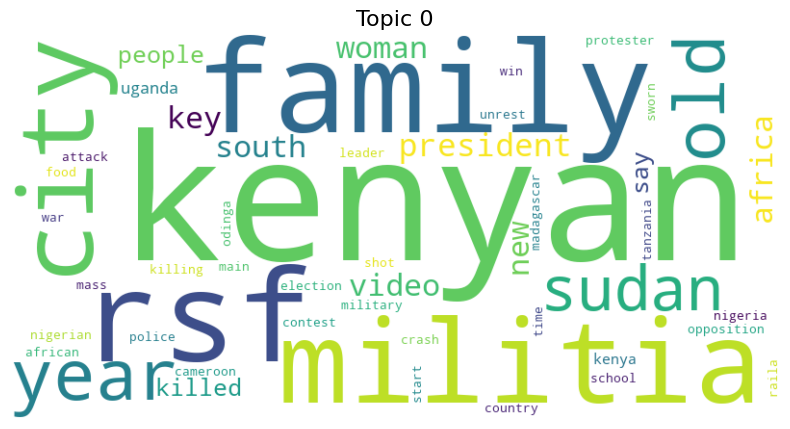

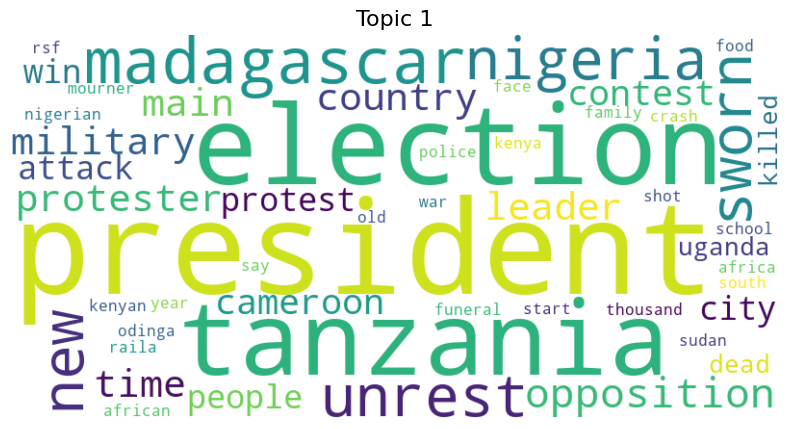

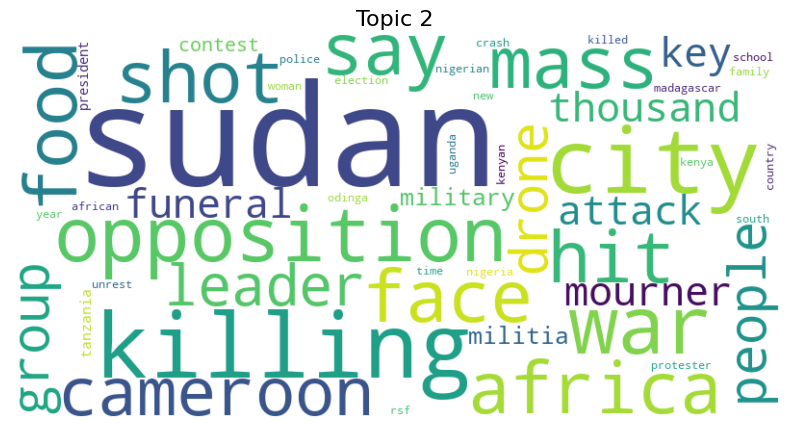

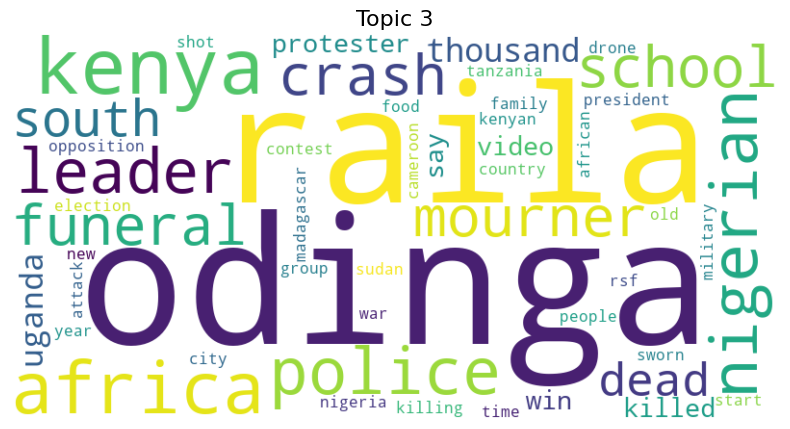

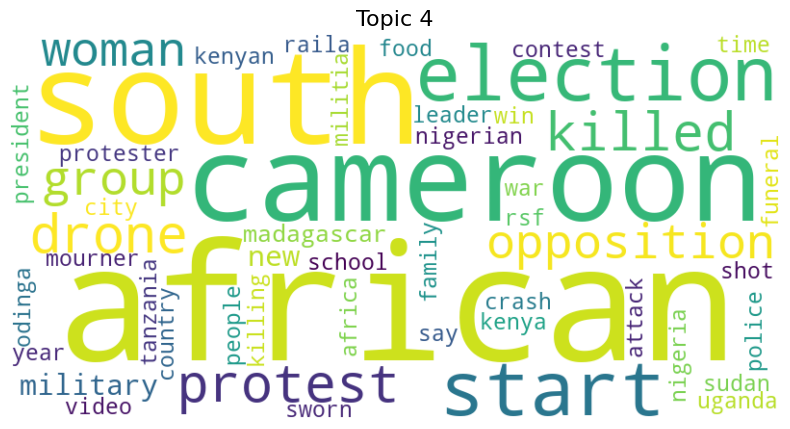

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to plot word cloud for a given topic
def plot_topic_wordcloud(lda_model, topic_id, max_words=50):
    topic_terms = dict(lda_model.show_topic(topic_id, topn=max_words))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_terms)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_id}', fontsize=16)
    plt.show()

# Generate word clouds for all topics
num_topics = lda_model.num_topics
for i in range(num_topics):
    plot_topic_wordcloud(lda_model, i)


Interpretation: Discuss which narratives dominate and any potential bias

In [22]:

topics = {i: [word for word, prob in lda_model.show_topic(i, topn=15)] for i in range(lda_model.num_topics)}

# Print topics with top words
for t, words in topics.items():
    print(f"Topic {t}: {', '.join(words)}")

# -------------------------------
# Interpretation
# -------------------------------
print("""
INTERPRETATION — POLITICAL NARRATIVES
-------------------------------------
The above topics reflect political patterns across BBC Africa headlines.

Possible dominant narratives:
• Frequent mentions of 'president', 'election', 'vote', or 'government' 
  → focus on leadership and electoral politics.
• Words like 'crisis', 'protest', 'military', 'conflict' 
  → political instability and governance challenges.
• Mentions of 'parliament', 'law', 'reform', 'party' 
  → coverage of institutional and policy aspects.

Potential biases:
• Emphasis on conflict and leadership crises may overrepresent negative political events.
• Positive governance or development reforms may receive less coverage.
• Certain countries or leaders might dominate the political narrative due to global media attention.
""")


Topic 0: kenyan, family, rsf, militia, city, year, old, sudan, president, africa, south, video, key, new, woman
Topic 1: president, election, tanzania, madagascar, sworn, nigeria, unrest, new, opposition, country, time, main, protester, military, leader
Topic 2: sudan, killing, city, war, opposition, hit, mass, shot, africa, face, say, food, cameroon, leader, group
Topic 3: odinga, raila, kenya, africa, police, nigerian, leader, school, mourner, funeral, crash, south, dead, thousand, uganda
Topic 4: african, south, cameroon, election, start, killed, protest, drone, opposition, group, woman, military, new, madagascar, video

INTERPRETATION — POLITICAL NARRATIVES
-------------------------------------
The above topics reflect political patterns across BBC Africa headlines.

Possible dominant narratives:
• Frequent mentions of 'president', 'election', 'vote', or 'government' 
  → focus on leadership and electoral politics.
• Words like 'crisis', 'protest', 'military', 'conflict' 
  → polit

# Part 2: News Category

In [9]:

import pandas as pd
import json

file_path = "News_Category_Dataset_v3.json"
df_news = pd.read_json(file_path, lines=True)

print("✅ Dataset Loaded Successfully!")
print(f"Total Records: {len(df_news)}")
df_news.head()


✅ Dataset Loaded Successfully!
Total Records: 209527


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


# Business Understanding (POLITICS THEME)

In [10]:

theme = "POLITICS"
df_theme = df_news[df_news['category'] == theme].copy()

print(f"✅ Selected Theme: {theme}")
print(f"Number of articles in this theme: {len(df_theme)}")
df_theme[['headline', 'category']].head()


✅ Selected Theme: POLITICS
Number of articles in this theme: 35602


,headline,category
21,Biden Says U.S. Forces Would Defend Taiwan If ...,POLITICS
24,‘Beautiful And Sad At The Same Time’: Ukrainia...,POLITICS
30,Biden Says Queen's Death Left 'Giant Hole' For...,POLITICS
40,Bill To Help Afghans Who Escaped Taliban Faces...,POLITICS
44,Mark Meadows Complies With Justice Dept. Subpo...,POLITICS


#  Data Understanding (Headlines and Categories Sample)

In [11]:

print("Sample Headlines and Categories:")
df_theme[['headline', 'category']].sample(10)


Sample Headlines and Categories:


,headline,category
36501,Has The ‘Presidential Pivot’ Finally Arrived?,POLITICS
81965,America’s Scientists To House Science Committe...,POLITICS
115761,The President of Israel Reaches Out to Palesti...,POLITICS
31102,'What Is The First Word That Comes To Mind Whe...,POLITICS
31456,Two Former Press Secretaries Have Some Advice ...,POLITICS
102546,Trail To The Chief: Meet Hillary's Team,POLITICS
93988,KKK And Black Justice Group Face Off On South ...,POLITICS
122018,ISIS: The Psychology of Our Fears,POLITICS
97785,More Physical Education Teachers Are Being Hir...,POLITICS
51406,Fusion Staff Votes Overwhelmingly To Unionize,POLITICS


#  Data Preparation (Cleaning and lemmatize headlines)

In [12]:

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(tokens)

df_theme['clean_headline'] = df_theme['headline'].apply(clean_text)
df_theme[['headline', 'clean_headline']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mgida\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mgida\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mgida\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,headline,clean_headline
21,Biden Says U.S. Forces Would Defend Taiwan If ...,biden say u force would defend taiwan china in...
24,‘Beautiful And Sad At The Same Time’: Ukrainia...,beautiful sad time ukrainian cultural festival...
30,Biden Says Queen's Death Left 'Giant Hole' For...,biden say queen death left giant hole royal fa...
40,Bill To Help Afghans Who Escaped Taliban Faces...,bill help afghan escaped taliban face long odd...
44,Mark Meadows Complies With Justice Dept. Subpo...,mark meadow complies justice dept subpoena report


#  Feature Engineering

In [13]:

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df_theme['clean_headline'])

print(f"DTM shape: {dtm.shape}")


DTM shape: (35602, 10309)


#  Modeling (LDA Topic Modeling)

In [14]:

from gensim import corpora, models
from gensim.utils import simple_preprocess

texts = [simple_preprocess(str(doc)) for doc in df_theme['clean_headline']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, passes=10)

print("✅ LDA Model Trained!")
lda_model.print_topics(num_words=10)


✅ LDA Model Trained!


[(0,
  '0.016*"court" + 0.012*"right" + 0.011*"supreme" + 0.010*"state" + 0.009*"new" + 0.009*"law" + 0.008*"huffpost" + 0.008*"gun" + 0.008*"police" + 0.006*"need"'),
 (1,
  '0.013*"obama" + 0.010*"change" + 0.010*"trump" + 0.009*"climate" + 0.009*"america" + 0.009*"gop" + 0.007*"black" + 0.007*"joe" + 0.007*"biden" + 0.007*"warren"'),
 (2,
  '0.028*"trump" + 0.016*"house" + 0.013*"obama" + 0.012*"white" + 0.011*"donald" + 0.009*"paul" + 0.008*"say" + 0.008*"bush" + 0.007*"republican" + 0.007*"gop"'),
 (3,
  '0.018*"gop" + 0.018*"sander" + 0.016*"bernie" + 0.015*"republican" + 0.015*"trump" + 0.011*"john" + 0.009*"senate" + 0.008*"party" + 0.008*"candidate" + 0.008*"bill"'),
 (4,
  '0.045*"clinton" + 0.035*"hillary" + 0.035*"trump" + 0.022*"donald" + 0.012*"obamas" + 0.011*"cruz" + 0.011*"ted" + 0.009*"email" + 0.008*"rubio" + 0.008*"american"')]

#  Evaluation — Topic Word Clouds

✅ Saved topic_0_wordcloud.png


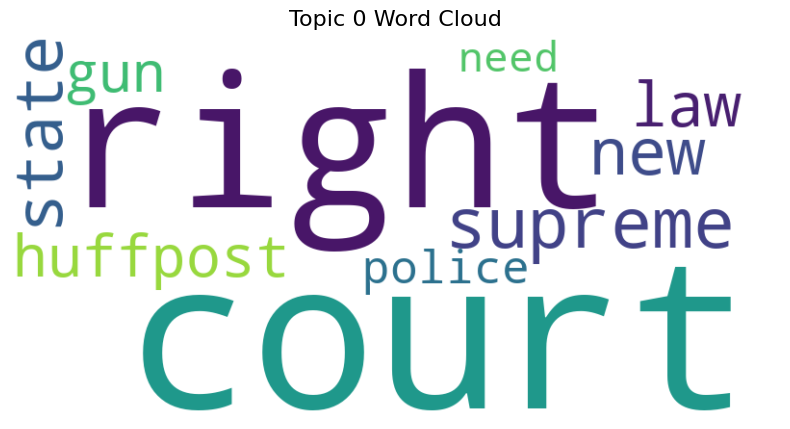

✅ Saved topic_1_wordcloud.png


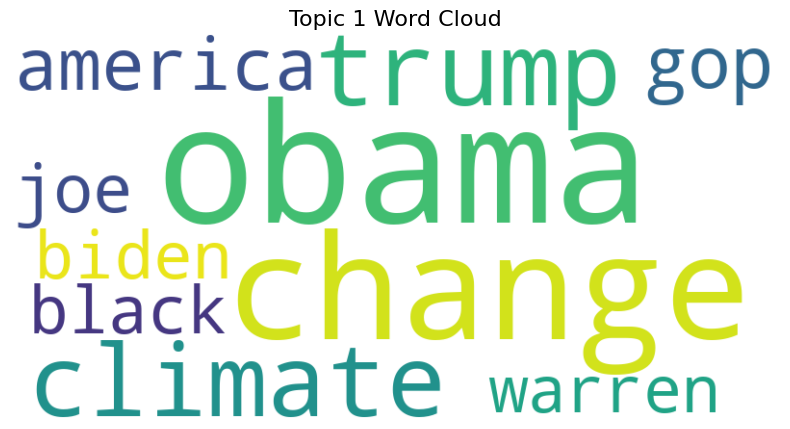

✅ Saved topic_2_wordcloud.png


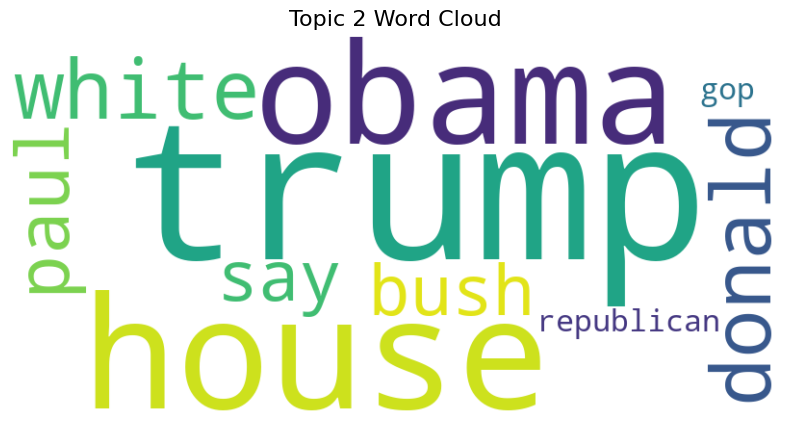

✅ Saved topic_3_wordcloud.png


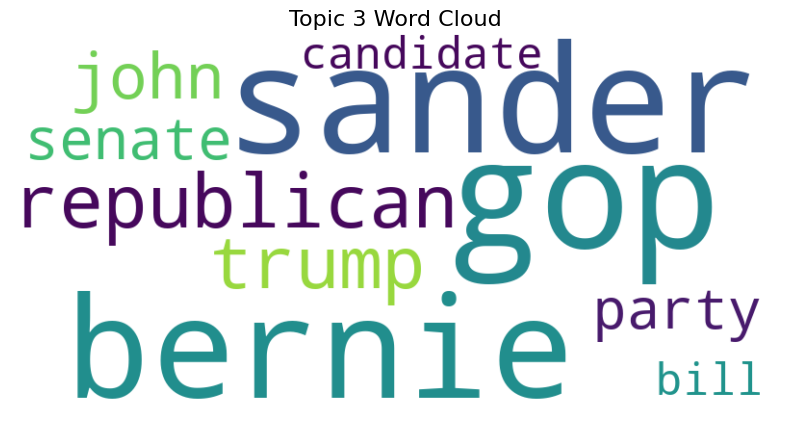

✅ Saved topic_4_wordcloud.png


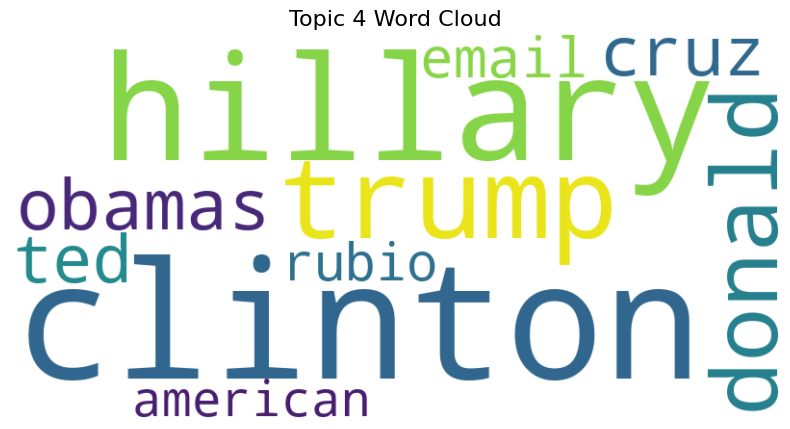

In [15]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt

for i, topic in lda_model.show_topics(num_topics=5, formatted=False):
    plt.figure(figsize=(8, 6))
    topic_words = dict(topic)
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {i} Word Cloud", fontsize=16)
    plt.tight_layout()
    filename = f"topic_{i}_wordcloud.png"
    plt.savefig(filename)
    print(f"✅ Saved {filename}")
    plt.show()


#  Interpretation

In [16]:

topics = lda_model.print_topics(num_topics=5, num_words=10)

print("🧭 Interpretation:")
for idx, topic in topics:
    print(f"\nTopic {idx}: {topic}")

print("""
💡 Observations:
- Topics often revolve around governance, elections, diplomacy, and policy.
- Some narratives may emphasize political conflict or leadership issues more heavily.
- BBC tends to maintain neutrality but framing can lean toward global political influence and governance stability themes.
""")


🧭 Interpretation:

Topic 0: 0.016*"court" + 0.012*"right" + 0.011*"supreme" + 0.010*"state" + 0.009*"new" + 0.009*"law" + 0.008*"huffpost" + 0.008*"gun" + 0.008*"police" + 0.006*"need"

Topic 1: 0.013*"obama" + 0.010*"change" + 0.010*"trump" + 0.009*"climate" + 0.009*"america" + 0.009*"gop" + 0.007*"black" + 0.007*"joe" + 0.007*"biden" + 0.007*"warren"

Topic 2: 0.028*"trump" + 0.016*"house" + 0.013*"obama" + 0.012*"white" + 0.011*"donald" + 0.009*"paul" + 0.008*"say" + 0.008*"bush" + 0.007*"republican" + 0.007*"gop"

Topic 3: 0.018*"gop" + 0.018*"sander" + 0.016*"bernie" + 0.015*"republican" + 0.015*"trump" + 0.011*"john" + 0.009*"senate" + 0.008*"party" + 0.008*"candidate" + 0.008*"bill"

Topic 4: 0.045*"clinton" + 0.035*"hillary" + 0.035*"trump" + 0.022*"donald" + 0.012*"obamas" + 0.011*"cruz" + 0.011*"ted" + 0.009*"email" + 0.008*"rubio" + 0.008*"american"

💡 Observations:
- Topics often revolve around governance, elections, diplomacy, and policy.
- Some narratives may emphasize po